# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

According to the **Materials and Methods** section paper provided, the dataset is collected over **17** campaigns between Mat 2008 and November 2010.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [923]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report, auc,PredictionErrorDisplay, mean_squared_error, f1_score, recall_score
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.inspection import permutation_importance

import warnings
warnings.simplefilter(action='ignore')

In [925]:
df = pd.read_csv("data/bank-additional-full.csv", sep = ';')

In [927]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [930]:
df.shape

(41188, 21)

In [932]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [934]:
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [936]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [938]:
# for col in df.columns:
#   value_counts = df[col].value_counts()
#   print(f'Value counts for {col}: {value_counts}\n")

# for col in df.columns:
#   unique_values = df[col].unique()
#   print(f"Unique values for {col}: {unique_values}\n")

In [940]:
# Features in dataset with Numeric values
numeric_columns = ["age", "duration", "campaign", "pdays", "previous", "emp.var.rate",
                   "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]

# Features in dataset with categorical values
categorical_columns = df.select_dtypes(include="object").columns

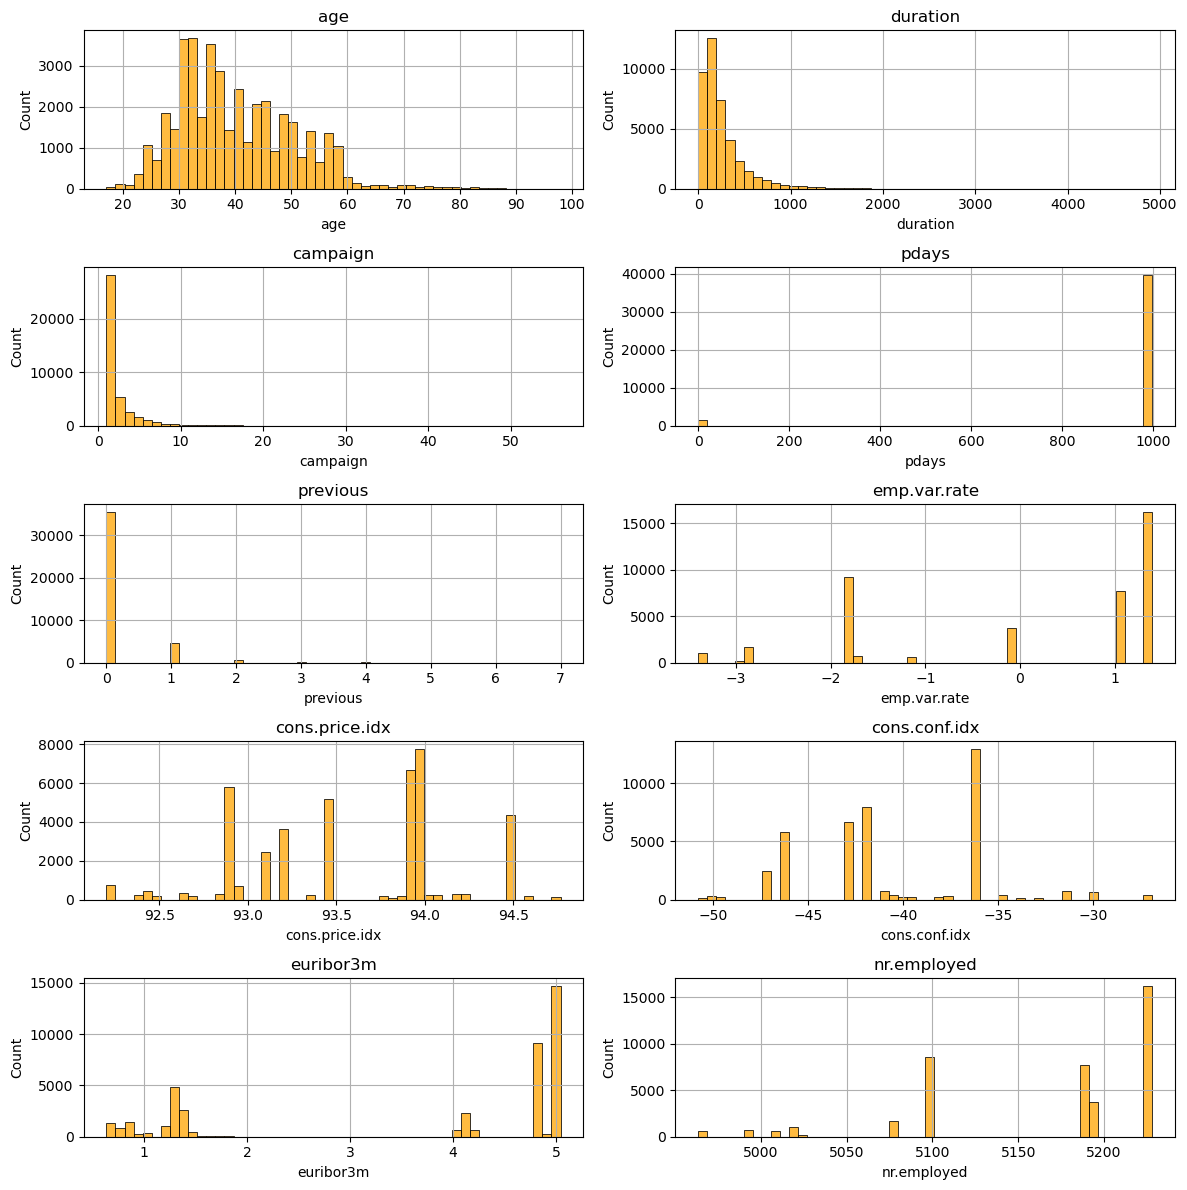

In [942]:
# Plotting the distribution of the values of numerical columns for understanding
plt.figure(figsize=(12, 12))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(5, 2, i)
    sns.histplot(df[col], bins=50, color="orange", edgecolor="black")
    plt.title(col)
    plt.grid(True)

plt.tight_layout()
plt.show()

In [943]:
# Plotting the acceptance of the offer by categories
def acceptance_distribution_by_category(x, df, category_name, hue="y", w=10, h=6):
    plt.rcParams["figure.figsize"] = [w, h]
    plt.rcParams["figure.autolayout"] = True

    ax = sns.countplot(x=x, hue=hue, data=df)
    ax.set_title(f"Bar plot for offer acceptance by {category_name}")
    for p in ax.patches:
        ax.annotate("{:.1f}".format(p.get_height()), (p.get_x() + 0.2, p.get_height()), ha="center", va="bottom")

    ax.set_xlabel(category_name)
    ax.set_ylabel("Count")
    plt.xticks(rotation=90)
    # plt.savefig(f"images/bar_plot_by_{x}")
    plt.show()

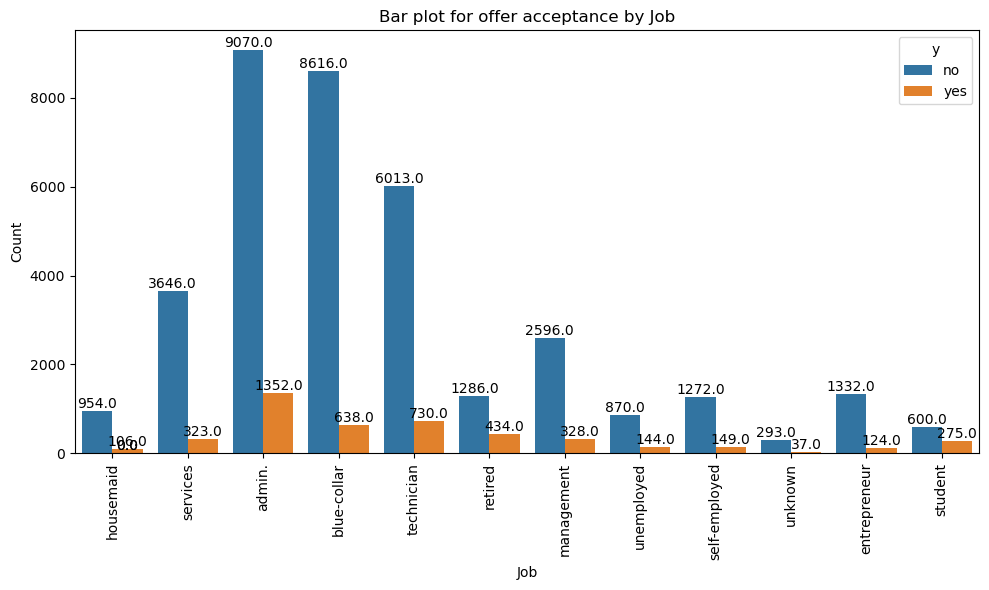

In [946]:
acceptance_distribution_by_category("job", df, "Job")

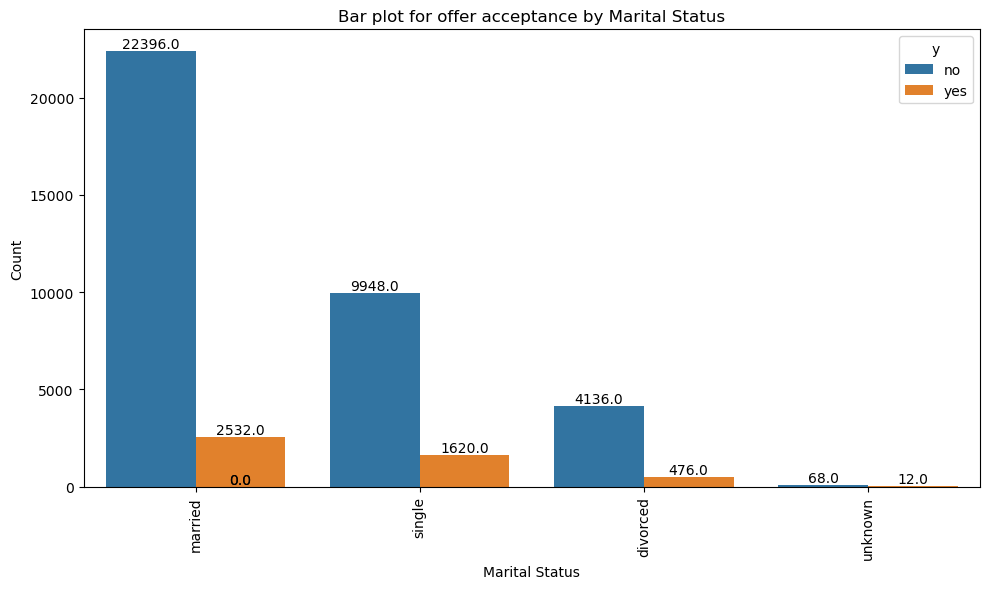

In [948]:
acceptance_distribution_by_category("marital", df, "Marital Status")

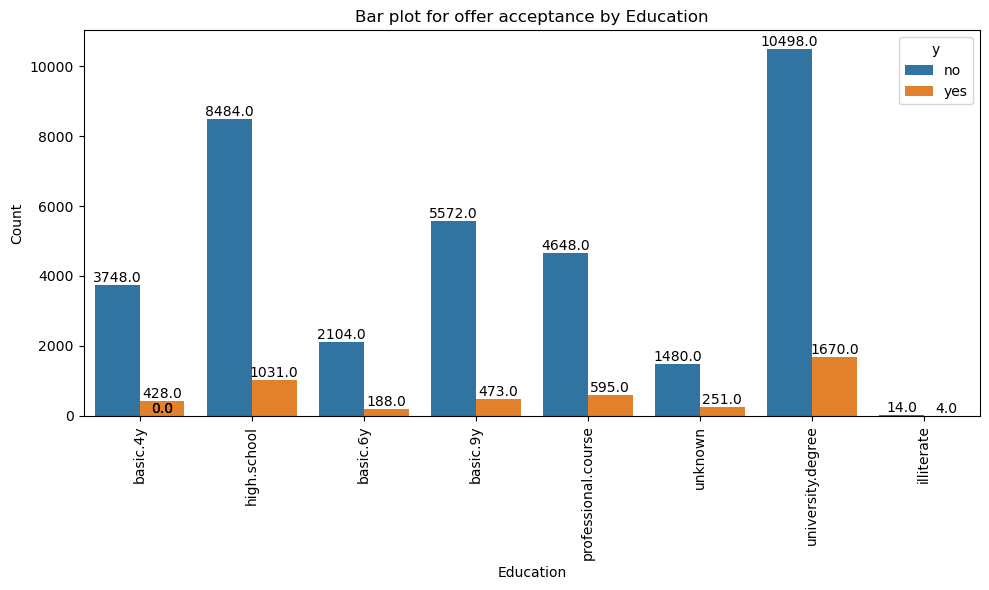

In [950]:
acceptance_distribution_by_category("education", df, "Education")

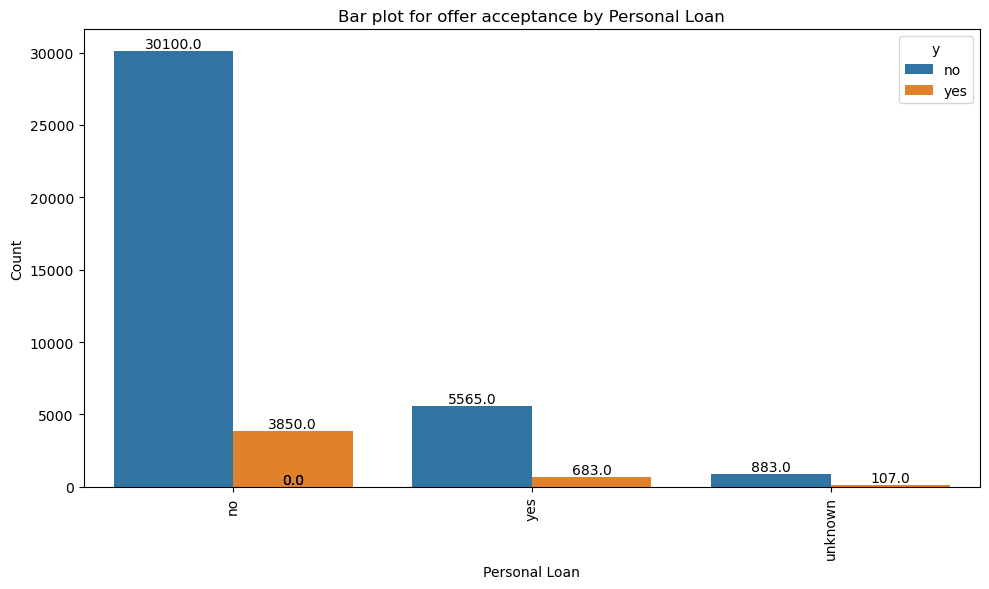

In [952]:
acceptance_distribution_by_category("loan", df, "Personal Loan")

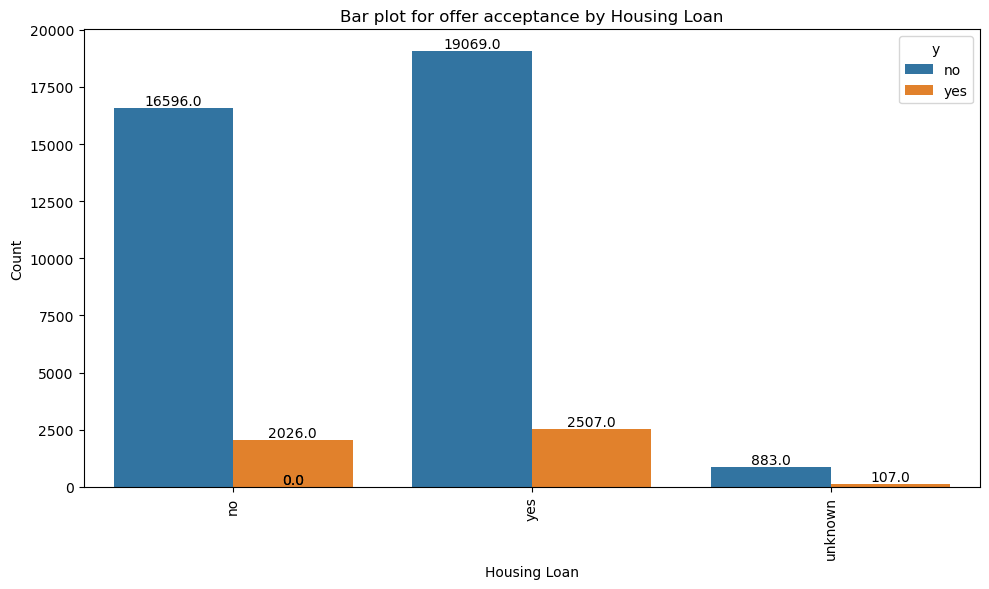

In [954]:
acceptance_distribution_by_category("housing", df, "Housing Loan")

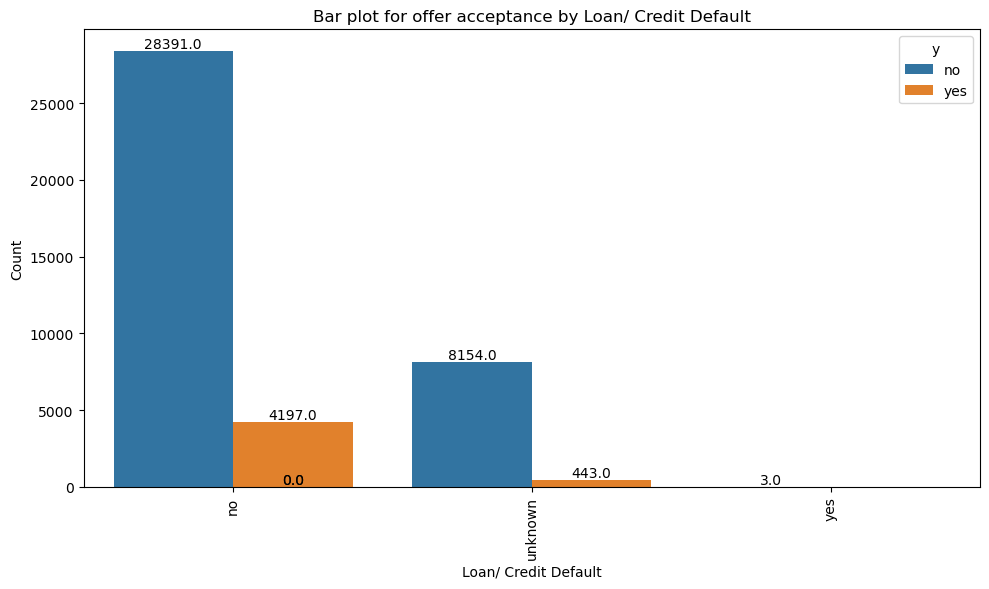

In [956]:
acceptance_distribution_by_category("default", df, "Loan/ Credit Default")

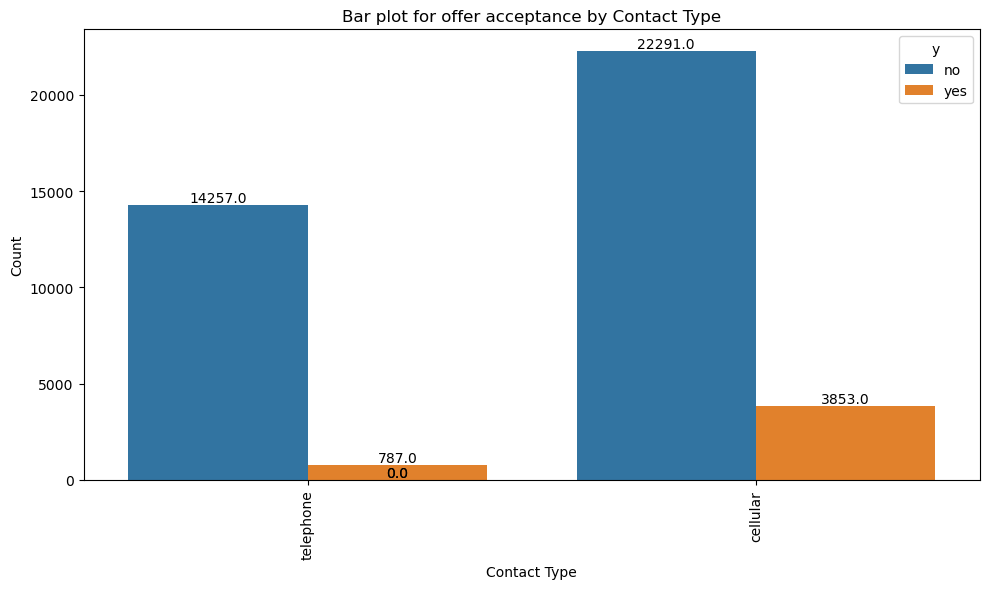

In [958]:
acceptance_distribution_by_category("contact", df, "Contact Type")

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [961]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

**Business Objective:**

This dataset comes from a Portuguese bank's marketing campaign aimed at getting customers to sign up for a long-term deposit. The goal of this analysis is to build a model that helps predict which customers are more likely to say "yes" when contacted and what are the most important attributes to focus on. At the same time, by analysing the performance of different models, we determine which model is best suited for the given dataset and relevance to the use case.

Such a model can make future campaigns more efficient by highlighting the key traits of likely customers. This helps the marketing team focus their time, calls, and efforts on the right people.

The data shows that past campaigns had low success rates. So, the main task of this machine learning project is to uncover what factors or combinations of factors lead to better results—and use that insight to improve future campaign performance.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [966]:
# Transforming the column to have numerical values
numerical_columns = [
    'age', 'duration', 'campaign', 'pdays', 'previous',
    'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'
]

categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('y')  


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

# Apply the transformer
data_pre = df.drop(columns=['y'])
data_trans = preprocessor.fit_transform(data_pre)

# Get feature names
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
all_feature_names = numerical_columns + list(cat_feature_names)

# Create the transformed DataFrame
trans_df = pd.DataFrame(data_trans, columns=all_feature_names)

le = LabelEncoder()
trans_df["y"] = le.fit_transform(df["y"])

In [968]:
trans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 64 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  float64
 1   duration                       41188 non-null  float64
 2   campaign                       41188 non-null  float64
 3   pdays                          41188 non-null  float64
 4   previous                       41188 non-null  float64
 5   emp.var.rate                   41188 non-null  float64
 6   cons.price.idx                 41188 non-null  float64
 7   cons.conf.idx                  41188 non-null  float64
 8   euribor3m                      41188 non-null  float64
 9   nr.employed                    41188 non-null  float64
 10  job_admin.                     41188 non-null  float64
 11  job_blue-collar                41188 non-null  float64
 12  job_entrepreneur               41188 non-null 

In [970]:
trans_df.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y
0,1.533034,0.010471,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,1.628993,-0.421501,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,-0.290186,-0.124520,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,-0.002309,-0.413787,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,1.533034,0.187888,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0


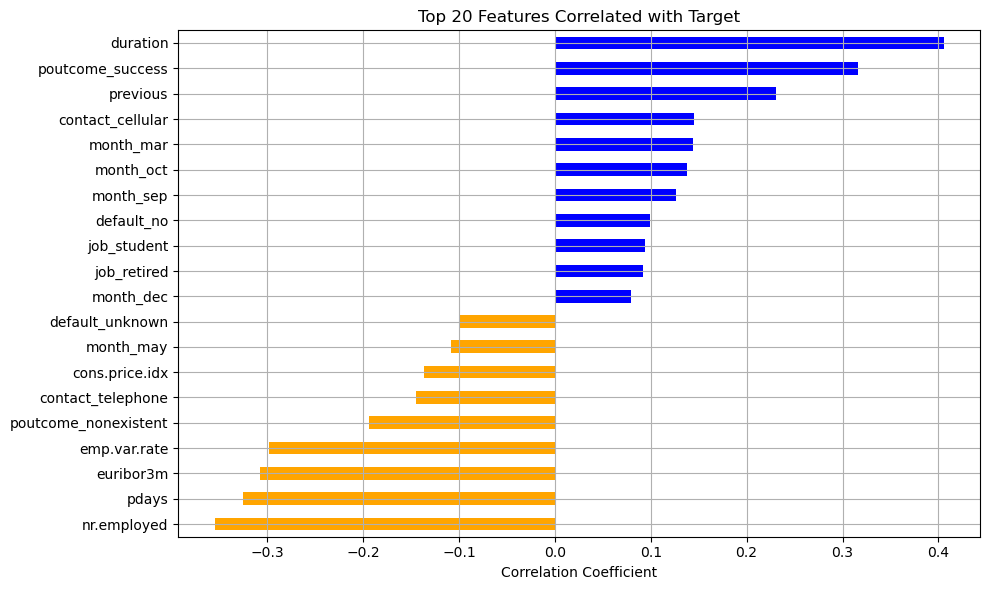

In [972]:
#  Correlation of features with target
correlations = trans_df.corr()['y'].drop('y')

#  Select top 10 by absolute value
top_features = correlations.abs().sort_values(ascending=False).head(20).index
top_20_corr = correlations[top_features]

top_20_corr = top_20_corr.sort_values()
colors = ['blue' if val > 0 else 'orange' for val in top_20_corr]

plt.figure(figsize=(10, 6))
top_20_corr.sort_values().plot(kind='barh', color=colors)
plt.title('Top 20 Features Correlated with Target')
plt.xlabel('Correlation Coefficient')
plt.grid(True)
plt.tight_layout()
plt.show()


In [973]:
# record and print model scores
def print_record_scores(model, train_time, train_accuracy, test_accuracy, recall_score):
  # Record the scores of baseline model
  fit_times.append(train_time)
  train_accuracies.append(train_accuracy)
  test_accuracies.append(test_accuracy)
  recalls.append(recall_score)

  # Print the scores
  print('='*30 + " Model Scores " + '='*30 + '\n')
  print("Model: {}".format(model))
  print("Train time: {}".format(train_time))
  print("Test Accuracy: {:.4f}".format(train_accuracy))
  print("Train Accuracy: {:.4f}".format(test_accuracy))
  print("Recall: {:.4f}".format(recall_score))

In [976]:
# Show metrics curves and reports in a subplot
def conf_matrix_roc_plot(model_name, model, X_test, y_test):
  print('='*100 + '\n')
  fig, axes = plt.subplots(1, 2, figsize=(12, 6))
  axes = axes.ravel()

  # Build Confusion Matrix
  disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=axes[0], display_labels=["No", "Yes"])
  cm = disp.confusion_matrix
  axes[0].set_title("Confusion Matrix")
  # Annotate TP, FP, FN, TN
  labels = np.array([["TN", "FP"], ["FN", "TP"]])
  for i in range(2):
      for j in range(2):
          axes[0].text(j, i, f"{labels[i, j]}\n",
                  ha="center", va="bottom", color="black", fontsize=12)

  # Build ROC Curve
  preds_proba = model.predict_proba(X_test)
  yes_probs = preds_proba[::,1]
  roc_yes_fp, roc_yes_tp, roc_yes_threshold = roc_curve(y_true=y_test,  y_score=yes_probs, pos_label=1)
  roc_no_fp, roc_no_tp, roc_no_threshold = roc_curve(y_true=y_test,  y_score=yes_probs, pos_label=0)
  axes[1].plot(roc_yes_fp, roc_yes_tp, label="Yes")
  axes[1].plot(roc_no_fp, roc_no_tp, label="No")
  axes[1].legend(loc="upper left")
  axes[1].set_title('ROC Curve', size=12)
  axes[1].plot([0, 1], [0, 1], color='green', linestyle=':')
  axes[1].set_ylabel('True Positive Rate')
  axes[1].set_xlabel('False Positive Rate')

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [979]:
X = trans_df.drop('y', axis=1)
y = trans_df['y']

X.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,1.533034,0.010471,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.628993,-0.421501,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.290186,-0.124520,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.002309,-0.413787,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.533034,0.187888,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [981]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32950, 63), (8238, 63), (32950,), (8238,))

In [983]:
y_test

14455    0
36380    0
40076    0
10778    0
27939    0
        ..
33359    1
34998    0
39861    0
3920     0
33395    0
Name: y, Length: 8238, dtype: int64

In [985]:
X_test.head(5)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
14455,-0.769980,-0.490925,0.878132,0.195414,-0.349494,0.839061,0.591424,-0.474791,0.772422,0.845170,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
36380,-0.290186,-0.610488,-0.565922,0.195414,-0.349494,-1.898153,-1.058448,-0.064259,-1.360272,-1.257233,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
40076,3.164336,-0.490925,-0.204909,0.195414,-0.349494,-1.134279,1.104525,0.043776,-1.620876,-2.428157,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
10778,0.381527,-0.811047,-0.204909,0.195414,-0.349494,0.839061,1.536429,-0.280328,0.772422,0.845170,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
27939,-1.153816,-0.440785,-0.204909,0.195414,-0.349494,-1.197935,-1.265761,-2.052098,-1.205177,-0.940281,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [1037]:
# Variables to record metrics
models = ["DummyClassifier", "LogisticRegression", "DecisionTree", "KNN", "SVM"]
fit_times = []
test_accuracies = []
train_accuracies = []
recalls = []


============================== Model Scores ==============================

Model: Baseline model
Train time: 0.03749990463256836
Test Accuracy: 0.8002
Train Accuracy: 0.8037
Recall: 0.1196



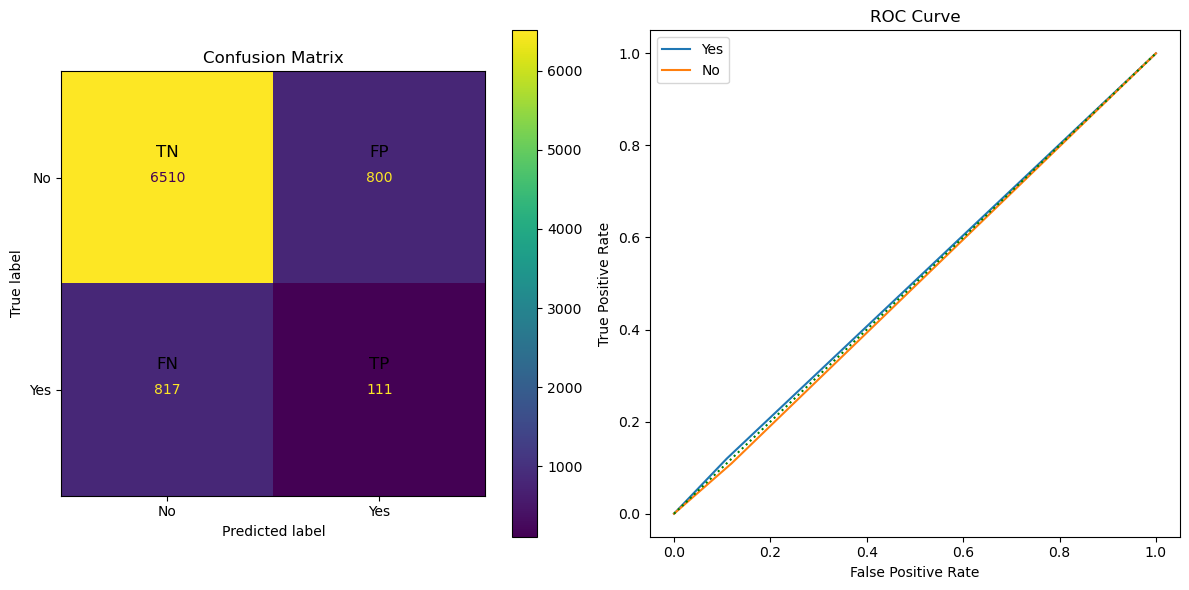

In [1039]:
######### Baseline (Dummy) Model #########
base_pipe = Pipeline ([
    ('scale', StandardScaler(with_mean=False)),
    ('model', DummyClassifier(random_state=42, strategy='stratified'))
])

# Train the base model
base_start_time = time.time()
base_pipe.fit(X_train, y_train)

# accuracy scores
train_pred_base = base_pipe.predict(X_train)
test_pred_base = base_pipe.predict(X_test)
base_end_time = time.time()
base_time_taken = (base_end_time - base_start_time) # seconds

base_train_acc = accuracy_score(y_train, train_pred_base)
base_test_acc = accuracy_score(y_test, test_pred_base)
base_recall_score = recall_score(y_test, test_pred_base)

print_record_scores("Baseline model", base_time_taken, base_train_acc, base_test_acc, base_recall_score)
conf_matrix_roc_plot("Baseline model", base_pipe, X_test, y_test)

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [1043]:
######### Logistic Regression Model #########
lr_pipe = Pipeline ([
    ('scale', StandardScaler()),
    ('logisticRegression', LogisticRegression(random_state=42, max_iter=1000))
])

lr_start_time = time.time()
lr_pipe.fit(X_train, y_train)
lr_train_pred = lr_pipe.predict(X_train)
lr_test_pred = lr_pipe.predict(X_test)
lr_end_time = time.time()
lr_time_taken = (lr_end_time - lr_start_time) # seconds

### Problem 9: Score the Model

What is the accuracy of your model?

============================== Model Scores ==============================

Model: Logistic Regression model
Train time: 0.1412980556488037
Test Accuracy: 0.9103
Train Accuracy: 0.9164
Recall: 0.4353



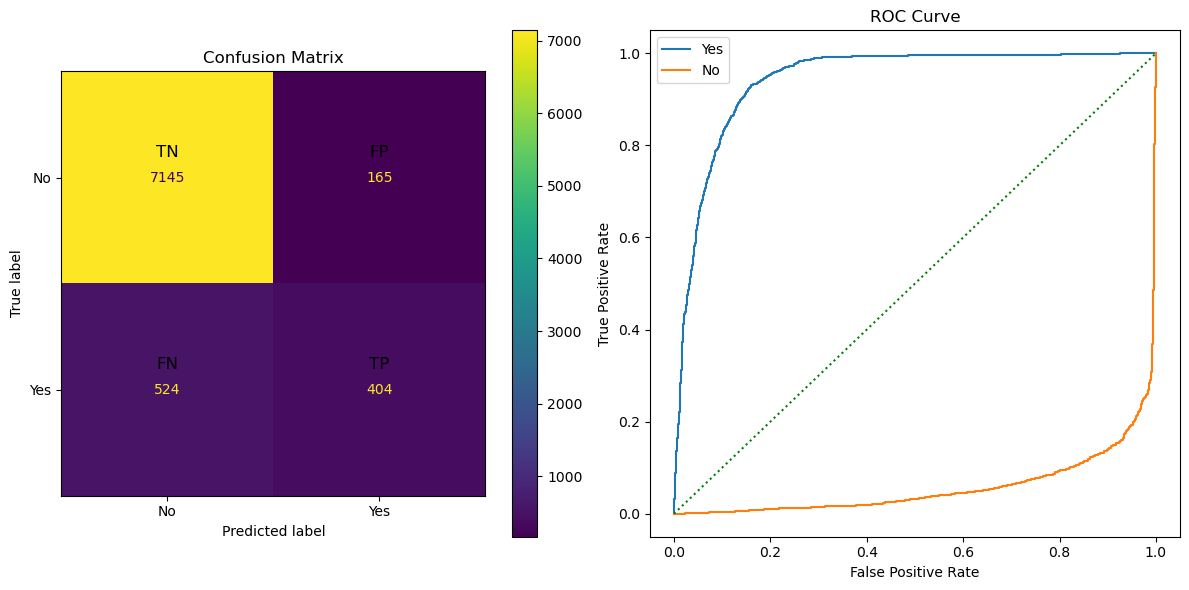

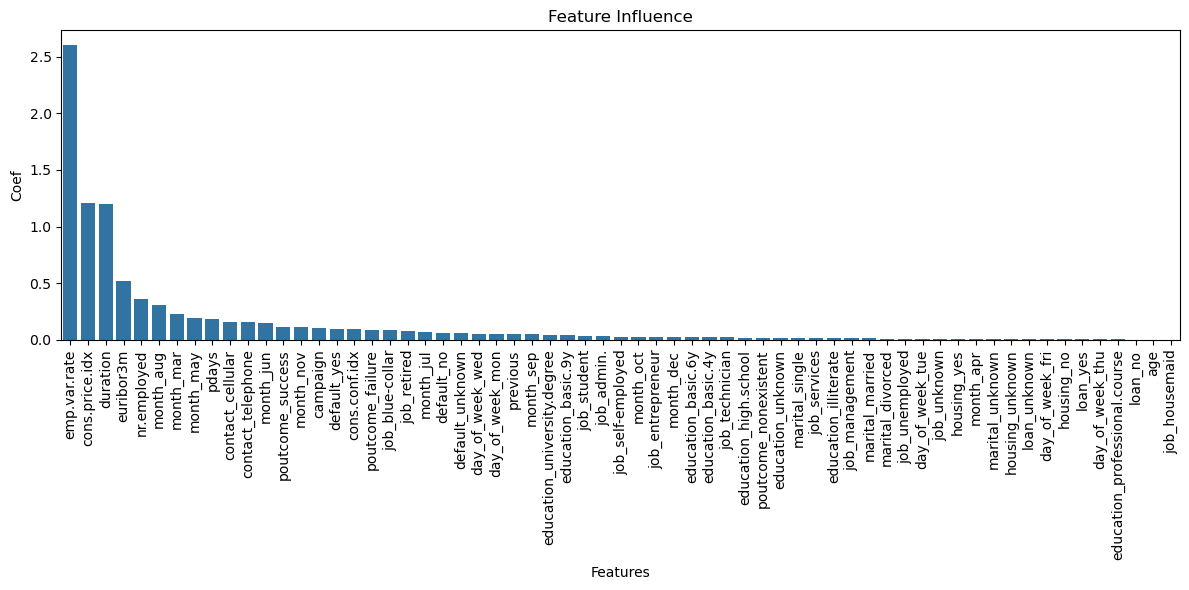

In [1046]:
# accuracy scores
lr_train_acc = accuracy_score(y_train, lr_train_pred)
lr_test_acc = accuracy_score(y_test, lr_test_pred)
lr_recall_score = recall_score(y_test, lr_test_pred)

print_record_scores("Logistic Regression model", lr_time_taken, lr_train_acc, lr_test_acc, lr_recall_score)
conf_matrix_roc_plot("Logistic Regression model", lr_pipe, X_test, y_test)


# plotting the influence of each feature on the target
feature_coef = pd.DataFrame({
    'coef': np.abs(lr_pipe.named_steps["logisticRegression"].coef_[0])
}, index=X_train.columns).sort_values(by="coef", ascending=False)

feature_coef = feature_coef.reset_index()
feature_coef.columns = ["Features", "Coef"]
plt.figure(figsize=(12, 6))
plt.title("Feature Influence")
sns.barplot(data=feature_coef, x="Features", y="Coef")
plt.xticks(rotation=90);

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

============================== Model Scores ==============================

Model: Decision Tree model
Train time: 0.1918809413909912
Test Accuracy: 1.0000
Train Accuracy: 0.8961
Recall: 0.5388



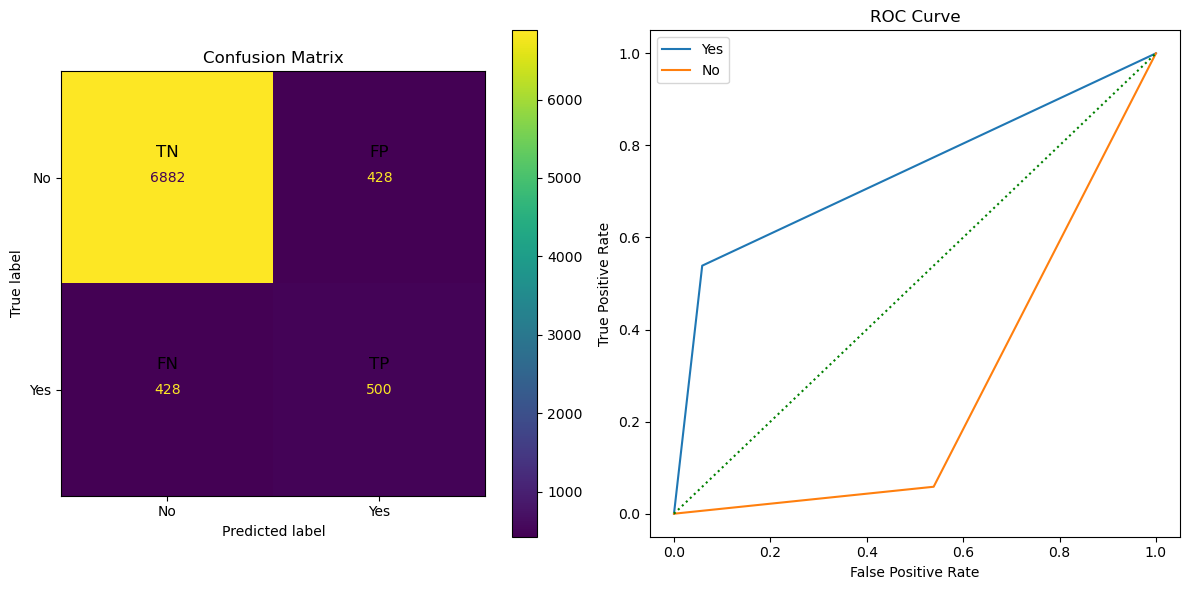

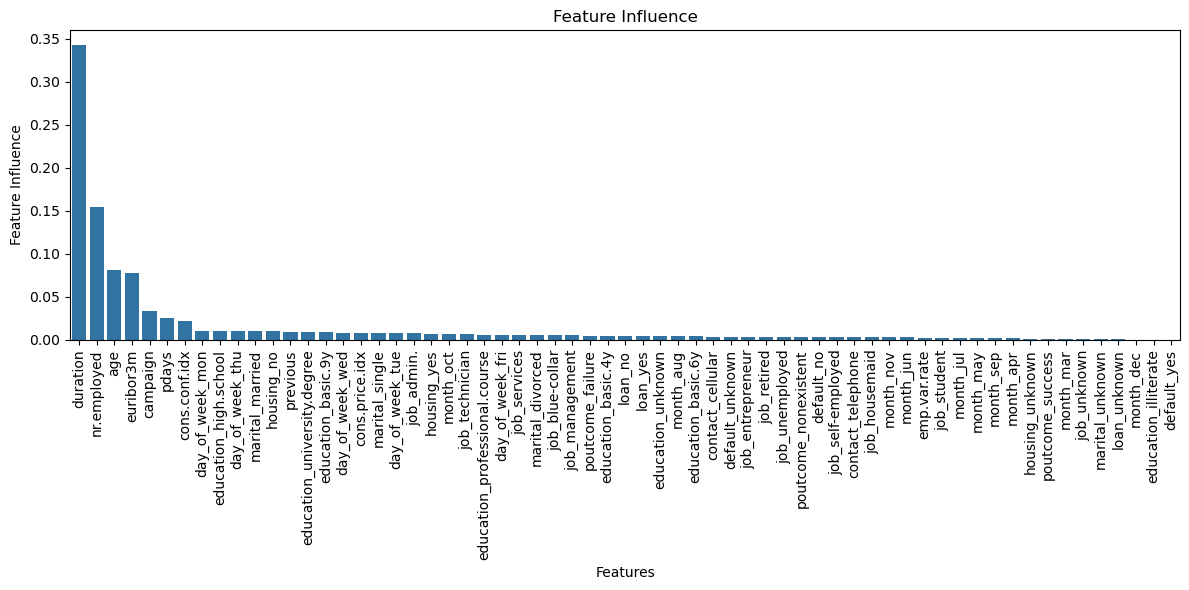

In [1049]:
######### Decision Tree Model #########
tree_pipe = Pipeline ([
    ('scale', StandardScaler()),
    ('dtree', DecisionTreeClassifier(random_state=42))
])

tree_start_time = time.time()
tree_pipe.fit(X_train, y_train)

# accuracy scores
tree_train_pred = tree_pipe.predict(X_train)
tree_test_pred = tree_pipe.predict(X_test)
tree_end_time = time.time()
tree_time_taken = (tree_end_time - tree_start_time) # seconds

tree_train_acc = accuracy_score(y_train, tree_train_pred)
tree_test_acc = accuracy_score(y_test, tree_test_pred)
tree_recall_score = recall_score(y_test, tree_test_pred)

print_record_scores("Decision Tree model", tree_time_taken, tree_train_acc, tree_test_acc, tree_recall_score)
conf_matrix_roc_plot("Decision Tree model", tree_pipe, X_test, y_test)

# plotting the influence of each feature on the target
features_df = pd.DataFrame(index=X_train.columns, data=tree_pipe.named_steps["dtree"].feature_importances_, columns=["Feature Importance"]).sort_values(by="Feature Importance", ascending=False)
features_df = features_df.reset_index()
features_df.columns = ["Features", "Feature Influence"]
plt.figure(figsize=(12, 6))
plt.title("Feature Influence")
sns.barplot(data=features_df, x="Features", y="Feature Influence")
plt.xticks(rotation=90);

============================== Model Scores ==============================

Model: K-nearest Neighbors model
Train time: 10.210037231445312
Test Accuracy: 0.9189
Train Accuracy: 0.9008
Recall: 0.3233



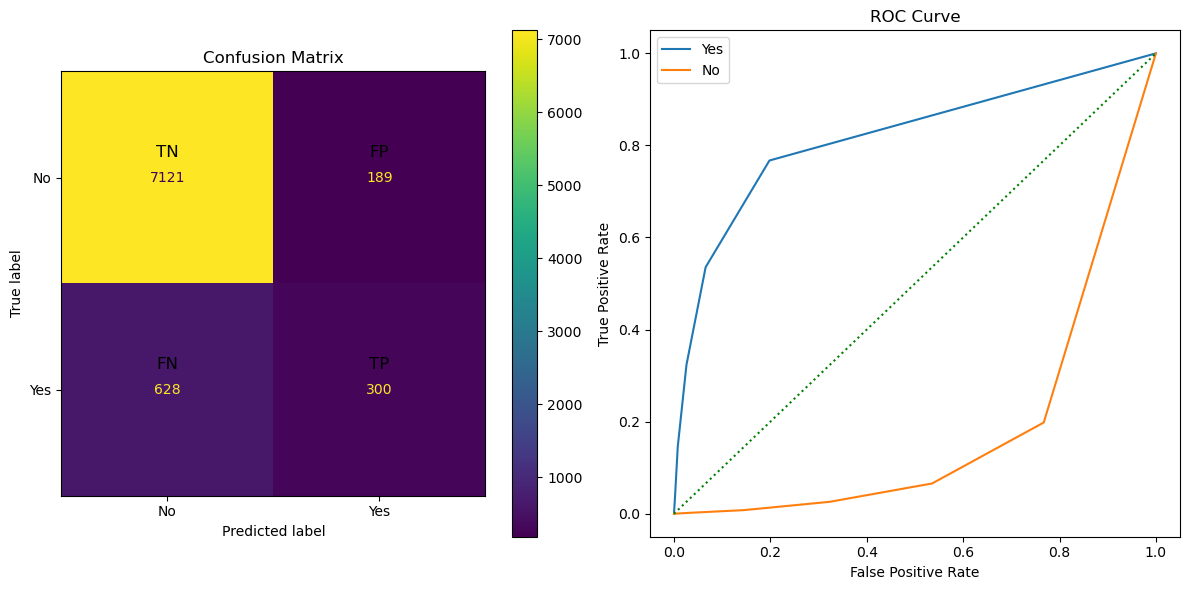

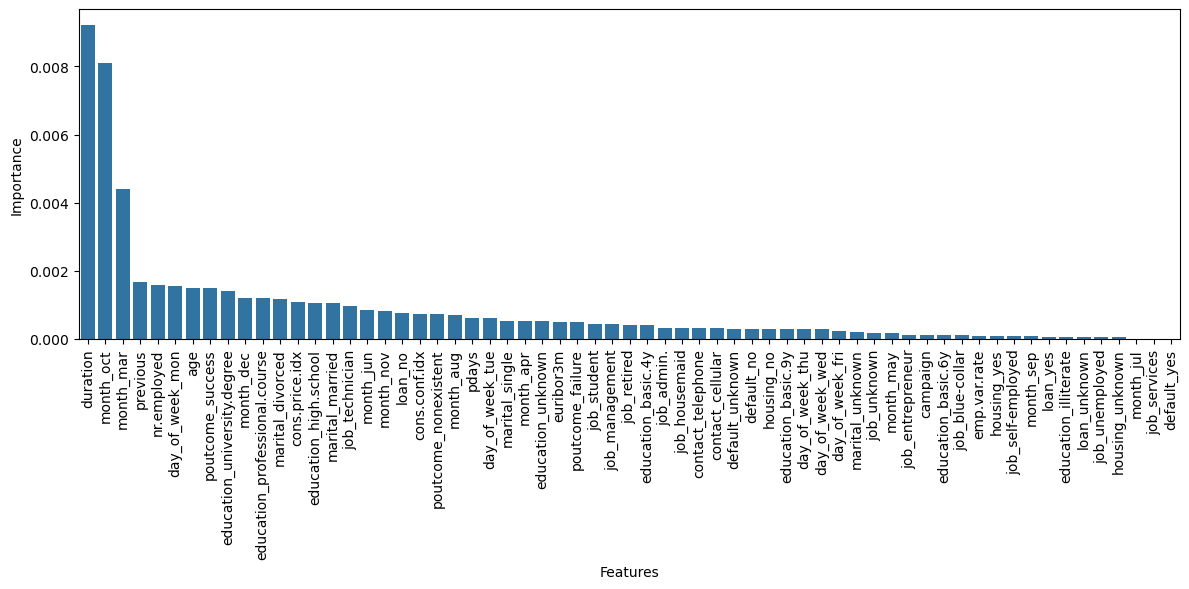

In [1051]:
######### K-nearest Neighbors Model #########
knn_pipe = Pipeline ([
    ('scale', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

knn_start_time = time.time()
knn_pipe.fit(X_train, y_train)
knn_end_time = time.time()
knn_time_taken = (knn_end_time - knn_start_time) * 1000 # millis

# accuracy scores
knn_train_pred = knn_pipe.predict(X_train)
knn_train_acc = accuracy_score(y_train, knn_train_pred)
knn_test_pred = knn_pipe.predict(X_test)
knn_test_acc = accuracy_score(y_test, knn_test_pred)
knn_recall_score = recall_score(y_test, knn_test_pred)

print_record_scores("K-nearest Neighbors model", knn_time_taken, knn_train_acc, knn_test_acc, knn_recall_score)
conf_matrix_roc_plot("K-nearest Neighbors model", knn_pipe, X_test, y_test)

# plotting the influence of each feature on the target
result = permutation_importance(knn_pipe, X_test, y_test, n_repeats=3)
result_df = pd.DataFrame(index=X_test.columns, data=np.abs(result.importances_mean), columns=['Importance'])
result_df = result_df.sort_values(by='Importance', ascending=False)
result_df = result_df.reset_index()
result_df.columns = ['Features', 'Importance']
plt.figure(figsize=(12, 6))
sns.barplot(data=result_df, x='Features', y='Importance')
plt.xticks(rotation=90);

============================== Model Scores ==============================

Model: Support Vector Machine Model
Train time: 73.3721559047699
Test Accuracy: 0.9268
Train Accuracy: 0.9136
Recall: 0.4019



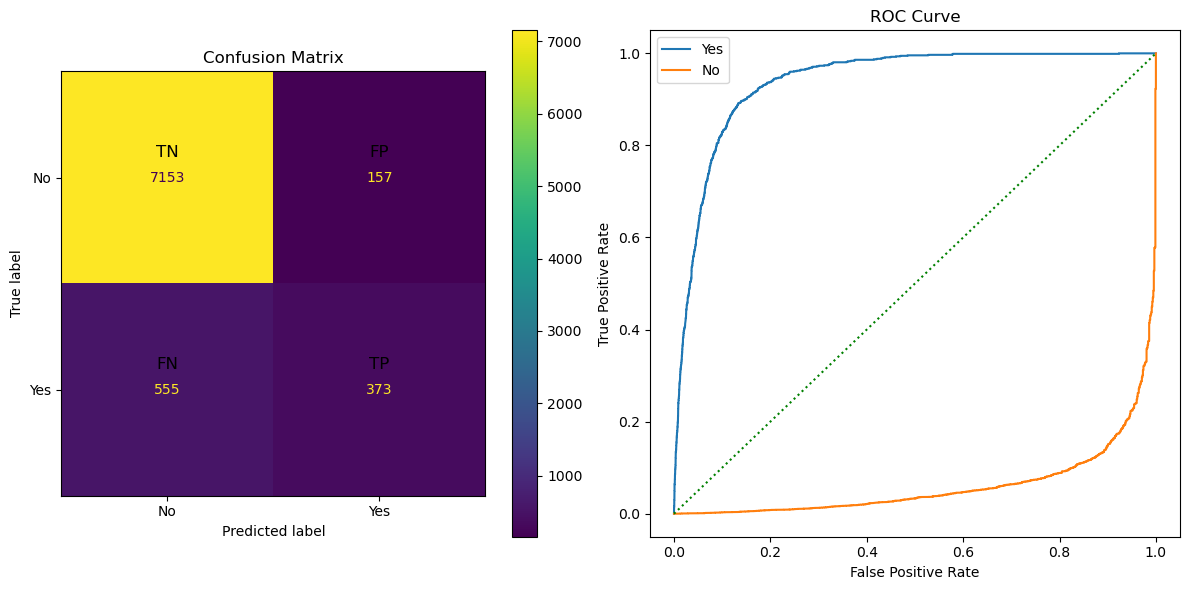

In [1052]:
######### Support Vector Machine Model #########
svm_pipe = Pipeline ([
    ('scale', StandardScaler()),
    ('svm', SVC(probability=True))
])

svm_start_time = time.time()
svm_pipe.fit(X_train, y_train)

# accuracy scores
svm_train_pred = svm_pipe.predict(X_train)
svm_test_pred = svm_pipe.predict(X_test)
svm_end_time = time.time()
svm_time_taken = (svm_end_time - svm_start_time) # seconds

svm_train_acc = accuracy_score(y_train, svm_train_pred)
svm_test_acc = accuracy_score(y_test, svm_test_pred)
svm_recall_score = recall_score(y_test, svm_test_pred)

print_record_scores("Support Vector Machine Model", svm_time_taken, svm_train_acc, svm_test_acc, svm_recall_score)
conf_matrix_roc_plot("Support Vector Machine Model", svm_pipe, X_test, y_test)

In [1053]:
# Accuracy and recal scores comparison for initial run of the models
metrics_df = pd.DataFrame({
    "Model": models,
    "Train Time": fit_times,
    "Train Accuracy": train_accuracies,
    "Test Accuracy": test_accuracies,
    "Recall Score": recalls
})
pd.set_option('display.max_colwidth', None)
metrics_df = metrics_df.set_index("Model")
metrics_df

,Train Time,Train Accuracy,Test Accuracy,Recall Score
Model,,,,
DummyClassifier,0.037500,0.800243,0.803714,0.119612
LogisticRegression,0.141298,0.910288,0.916363,0.435345
DecisionTree,0.191881,1.000000,0.896091,0.538793
KNN,10.210037,0.918877,0.900825,0.323276
SVM,73.372156,0.926798,0.913571,0.401940


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [1058]:
models = ['LogisticRegression', 'DecisionTree', 'KNN', 'SVM']
perf_fit_times = []
perf_test_accuracies = []
perf_train_accuracies = []
perf_recalls = []
perf_best_params = []
perf_best_scores = []

In [1060]:
# Helper method to print and record performance metrics for running grid search to tune hyperparameters for models
def print_perf_metrics(model, train_preds, test_preds, total_time_taken, best_param, best_score):
    train_acc = round(accuracy_score(y_train, train_preds), 4)
    test_acc = round(accuracy_score(y_test, test_preds), 4)
    r_score = round(recall_score(y_test, test_preds), 4)
    preds_proba = model.predict_proba(X_test)
    y_probs = preds_proba[::,1]
    auc = round(roc_auc_score(y_true=y_test, y_score=y_probs), 4)
    total_time_rounded = round(total_time_taken, 4)
    best_score_rounded = round(best_score, 4)
    
    

    perf_fit_times.append(total_time_rounded)
    perf_train_accuracies.append(train_acc)
    perf_test_accuracies.append(test_acc)
    perf_recalls.append(r_score)
    perf_best_params.append(model.get_params())
    perf_best_scores.append(best_score_rounded)

    print('='*30 + " Model Performance Metrics " + '='*30 + '\n')
    print("Total time: {}".format(total_time_rounded))
    print("Test Accuracy: {}".format(train_acc))
    print("Train Accuracy: {}".format(test_acc))
    print("Area under curve is {}".format(auc))
    print("Recall: {}".format(r_score))
    print("Best Score: {}".format(best_score_rounded))
    print(f"Best Params: {best_param}")

============================== Model Performance Metrics ==============================

Total time: 10.3318
Test Accuracy: 0.9101
Train Accuracy: 0.9164
Area under curve is 0.9424
Recall: 0.4364
Best Score: 0.9099
Best Params: {'logisticRegression__C': 1, 'logisticRegression__class_weight': None, 'logisticRegression__max_iter': 1000, 'logisticRegression__penalty': 'l2', 'logisticRegression__solver': 'liblinear'}



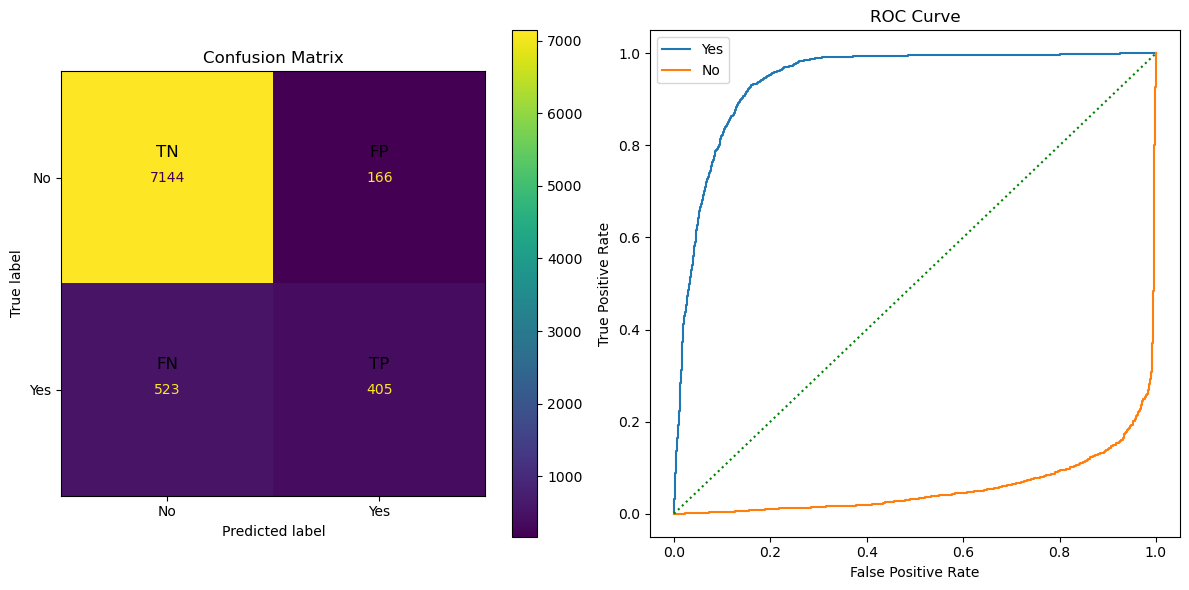

In [1062]:
# Running Grid search to find best Hyperparameter tuning for LogisticRegression
lr_start_time = time.time()
lr_param_grid = {
    'logisticRegression__C': [0.01, 0.1, 1, 10],
    'logisticRegression__class_weight': [None, 'balanced'],
    'logisticRegression__max_iter': [1000],
    'logisticRegression__penalty': ['l2'],
    'logisticRegression__solver': ['liblinear']
}

lr_grid = GridSearchCV(lr_pipe, lr_param_grid, cv=5, n_jobs=1, verbose=0, scoring={'accuracy': 'accuracy'}, refit='accuracy')
lr_grid.fit(X_train, y_train)
lr_test_preds = lr_grid.best_estimator_.predict(X_test)
lr_train_preds = lr_grid.best_estimator_.predict(X_train)
lr_end_time = time.time()
lr_time_taken = (lr_end_time - lr_start_time) #seconds

print_perf_metrics(lr_grid.best_estimator_, lr_train_preds, lr_test_preds, lr_time_taken, lr_grid.best_params_, lr_grid.best_score_)

conf_matrix_roc_plot("Logistic Regression Model with Tuned Hyperparameters", lr_grid.best_estimator_, X_test, y_test)

============================== Model Performance Metrics ==============================

Total time: 5.3288
Test Accuracy: 0.916
Train Accuracy: 0.9185
Area under curve is 0.9328
Recall: 0.528
Best Score: 0.912
Best Params: {'dtree__criterion': 'gini', 'dtree__max_depth': 5, 'dtree__min_samples_split': 2}



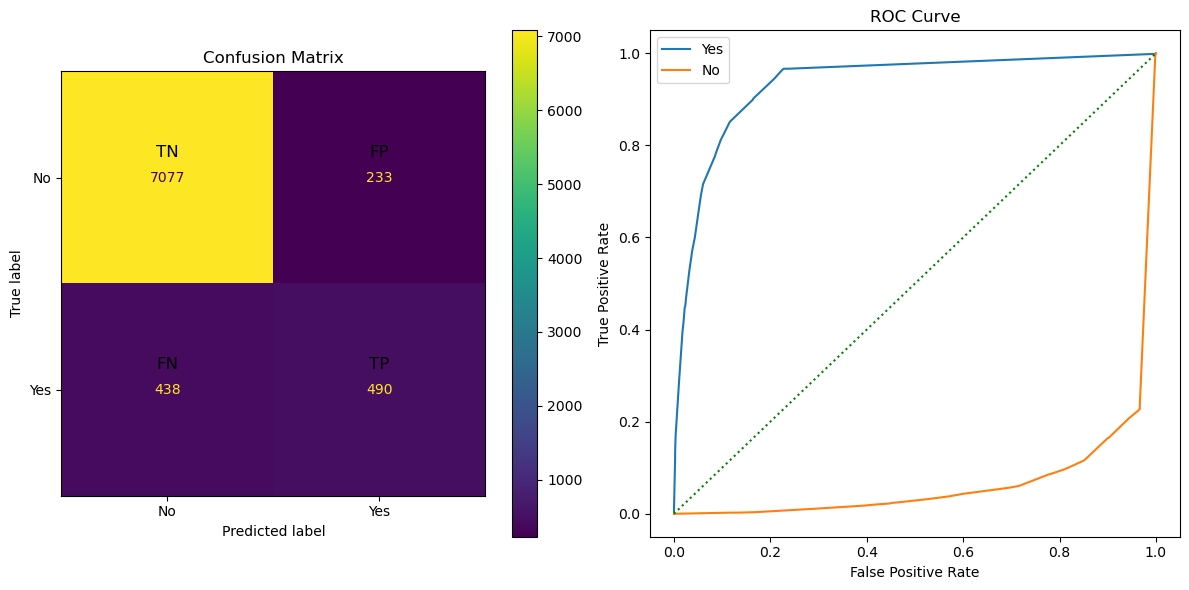

In [1064]:
# Running Grid search to find best Hyperparameter tuning for DecisionTree model
dtree_start_time = time.time()
dtree_param_grid = {
    'dtree__criterion': ['gini', 'entropy'],       # splitting criterion
    'dtree__max_depth': [3, 5, 10],                # maximum depth of the tree
    'dtree__min_samples_split': [2, 5, 10],        # minimum samples required to split
}

dtree_grid = GridSearchCV(tree_pipe, dtree_param_grid, cv=5, n_jobs=1, verbose=0, scoring={'accuracy': 'accuracy'}, refit='accuracy')
dtree_grid.fit(X_train, y_train)
dtree_test_preds = dtree_grid.best_estimator_.predict(X_test)
dtree_train_preds = dtree_grid.best_estimator_.predict(X_train)
dtree_end_time = time.time()
dtree_time_taken = (dtree_end_time - dtree_start_time) #seconds

print_perf_metrics(dtree_grid.best_estimator_, dtree_train_preds, dtree_test_preds, dtree_time_taken, dtree_grid.best_params_, dtree_grid.best_score_)

conf_matrix_roc_plot("Decision Tree Model with Tuned Hyperparameters", dtree_grid.best_estimator_, X_test, y_test)

============================== Model Performance Metrics ==============================

Total time: 37.266
Test Accuracy: 0.9033
Train Accuracy: 0.9036
Area under curve is 0.8758
Recall: 0.2597
Best Score: 0.8972
Best Params: {'knn__n_neighbors': 19, 'knn__weights': 'uniform'}



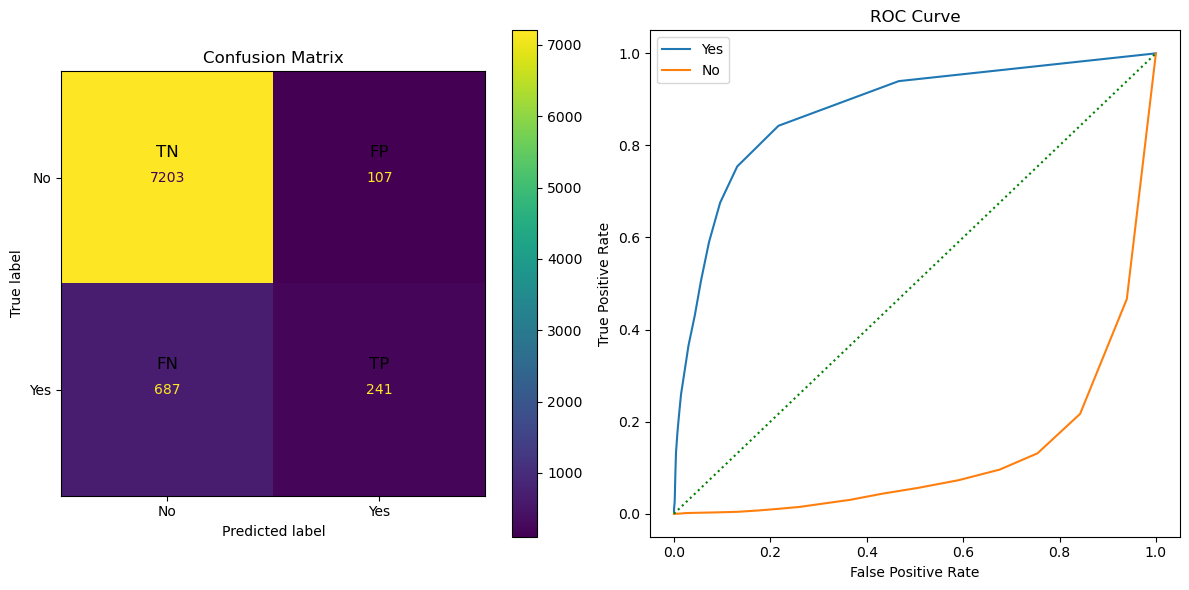

In [1066]:
# Running Grid search to find best Hyperparameter tuning for K-nearest Neighbors model
knn_start_time = time.time()
knn_param_grid = {
    'knn__n_neighbors': list(range(1, 20)),       # number of neighbors to use
    'knn__weights': ['uniform', 'distance'],      # weighting strategy
}

knn_grid = GridSearchCV(knn_pipe, knn_param_grid, cv=5, n_jobs=1, verbose=0, scoring={'accuracy': 'accuracy'}, refit='accuracy')
knn_grid.fit(X_train, y_train)
knn_test_preds = knn_grid.best_estimator_.predict(X_test)
knn_train_preds = knn_grid.best_estimator_.predict(X_train)
knn_end_time = time.time()
knn_time_taken = (knn_end_time - knn_start_time) #seconds

print_perf_metrics(knn_grid.best_estimator_, knn_train_preds, knn_test_preds, knn_time_taken, knn_grid.best_params_, knn_grid.best_score_)

conf_matrix_roc_plot("K-nearest Neighbors Model with Tuned Hyperparameters", knn_grid.best_estimator_, X_test, y_test)

============================== Model Performance Metrics ==============================

Total time: 2217.3239
Test Accuracy: 0.9268
Train Accuracy: 0.9136
Area under curve is 0.9393
Recall: 0.4019
Best Score: 0.9051
Best Params: {'svm__C': 1, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}



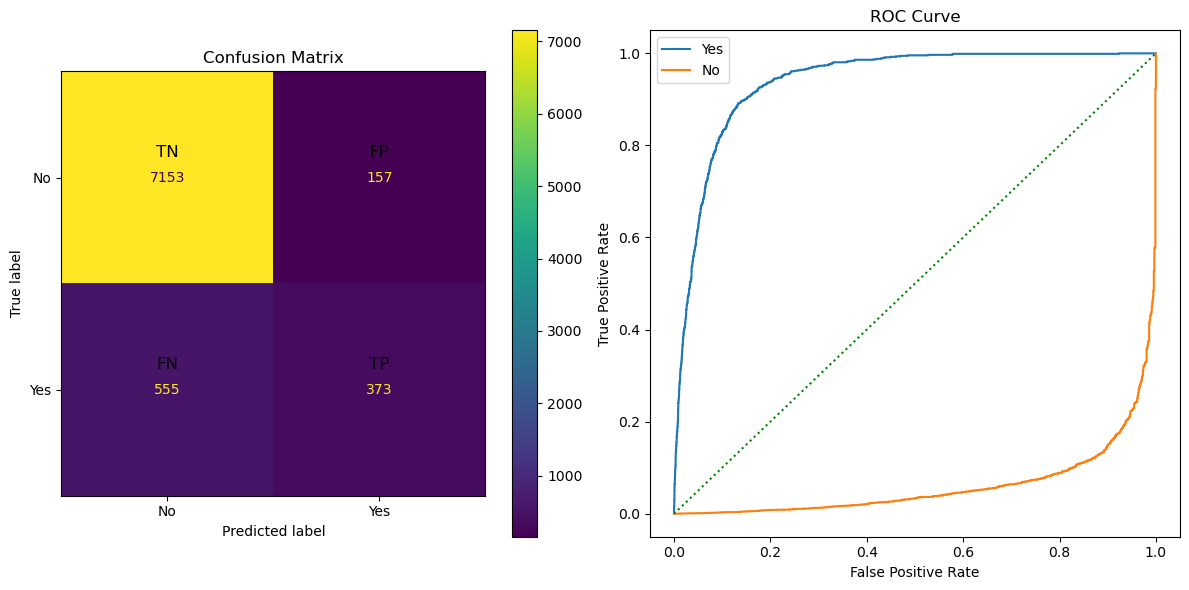

In [1068]:
# Running Grid search to find best Hyperparameter tuning for Support Vector Machine model
svm_start_time = time.time()
svm_param_grid = {
    'svm__C': [0.1, 1, 5],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['auto']
}

svm_grid = GridSearchCV(svm_pipe, svm_param_grid, cv=5, n_jobs=1, verbose=0, scoring={'accuracy': 'accuracy'}, refit='accuracy')
svm_grid.fit(X_train, y_train)
svm_test_preds = svm_grid.best_estimator_.predict(X_test)
svm_train_preds = svm_grid.best_estimator_.predict(X_train)
svm_end_time = time.time()
svm_time_taken = (svm_end_time - svm_start_time) #seconds

print_perf_metrics(svm_grid.best_estimator_, svm_train_preds, svm_test_preds, svm_time_taken, svm_grid.best_params_, svm_grid.best_score_)

conf_matrix_roc_plot("Support Vector Machine Model with Tuned Hyperparameters", svm_grid.best_estimator_, X_test, y_test)

In [1069]:
# Performance metrics for models with best hyperparameters
perf_metrics_df = pd.DataFrame({
    'Model': models,
    'Train Time': perf_fit_times,
    'Test Accuracy': perf_test_accuracies,
    'Train Accuracy': perf_train_accuracies,
    'Recall Score': perf_recalls,
    'Best Score': perf_best_scores,
    'Best Params': perf_best_params,
})

pd.set_option('display.max_colwidth', None)
perf_metrics_df = perf_metrics_df.set_index('Model')
perf_metrics_df

,Train Time,Test Accuracy,Train Accuracy,Recall Score,Best Score,Best Params
Model,,,,,,
LogisticRegression,10.3318,0.9164,0.9101,0.4364,0.9099,"{'memory': None, 'steps': [('scale', StandardScaler()), ('logisticRegression', LogisticRegression(C=1, max_iter=1000, random_state=42, solver='liblinear'))], 'verbose': False, 'scale': StandardScaler(), 'logisticRegression': LogisticRegression(C=1, max_iter=1000, random_state=42, solver='liblinear'), 'scale__copy': True, 'scale__with_mean': True, 'scale__with_std': True, 'logisticRegression__C': 1, 'logisticRegression__class_weight': None, 'logisticRegression__dual': False, 'logisticRegression__fit_intercept': True, 'logisticRegression__intercept_scaling': 1, 'logisticRegression__l1_ratio': None, 'logisticRegression__max_iter': 1000, 'logisticRegression__multi_class': 'deprecated', 'logisticRegression__n_jobs': None, 'logisticRegression__penalty': 'l2', 'logisticRegression__random_state': 42, 'logisticRegression__solver': 'liblinear', 'logisticRegression__tol': 0.0001, 'logisticRegression__verbose': 0, 'logisticRegression__warm_start': False}"
DecisionTree,5.3288,0.9185,0.9160,0.5280,0.9120,"{'memory': None, 'steps': [('scale', StandardScaler()), ('dtree', DecisionTreeClassifier(max_depth=5, random_state=42))], 'verbose': False, 'scale': StandardScaler(), 'dtree': DecisionTreeClassifier(max_depth=5, random_state=42), 'scale__copy': True, 'scale__with_mean': True, 'scale__with_std': True, 'dtree__ccp_alpha': 0.0, 'dtree__class_weight': None, 'dtree__criterion': 'gini', 'dtree__max_depth': 5, 'dtree__max_features': None, 'dtree__max_leaf_nodes': None, 'dtree__min_impurity_decrease': 0.0, 'dtree__min_samples_leaf': 1, 'dtree__min_samples_split': 2, 'dtree__min_weight_fraction_leaf': 0.0, 'dtree__monotonic_cst': None, 'dtree__random_state': 42, 'dtree__splitter': 'best'}"
KNN,37.2660,0.9036,0.9033,0.2597,0.8972,"{'memory': None, 'steps': [('scale', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=19))], 'verbose': False, 'scale': StandardScaler(), 'knn': KNeighborsClassifier(n_neighbors=19), 'scale__copy': True, 'scale__with_mean': True, 'scale__with_std': True, 'knn__algorithm': 'auto', 'knn__leaf_size': 30, 'knn__metric': 'minkowski', 'knn__metric_params': None, 'knn__n_jobs': None, 'knn__n_neighbors': 19, 'knn__p': 2, 'knn__weights': 'uniform'}"
SVM,2217.3239,0.9136,0.9268,0.4019,0.9051,"{'memory': None, 'steps': [('scale', StandardScaler()), ('svm', SVC(C=1, gamma='auto', probability=True))], 'verbose': False, 'scale': StandardScaler(), 'svm': SVC(C=1, gamma='auto', probability=True), 'scale__copy': True, 'scale__with_mean': True, 'scale__with_std': True, 'svm__C': 1, 'svm__break_ties': False, 'svm__cache_size': 200, 'svm__class_weight': None, 'svm__coef0': 0.0, 'svm__decision_function_shape': 'ovr', 'svm__degree': 3, 'svm__gamma': 'auto', 'svm__kernel': 'rbf', 'svm__max_iter': -1, 'svm__probability': True, 'svm__random_state': None, 'svm__shrinking': True, 'svm__tol': 0.001, 'svm__verbose': False}"


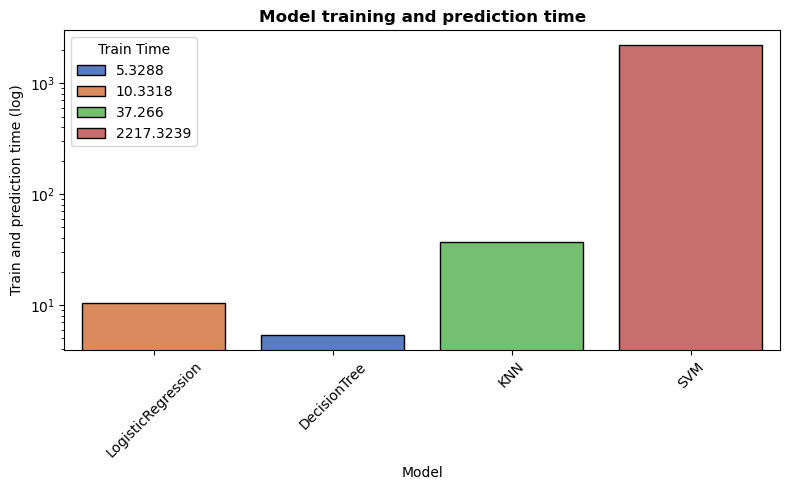

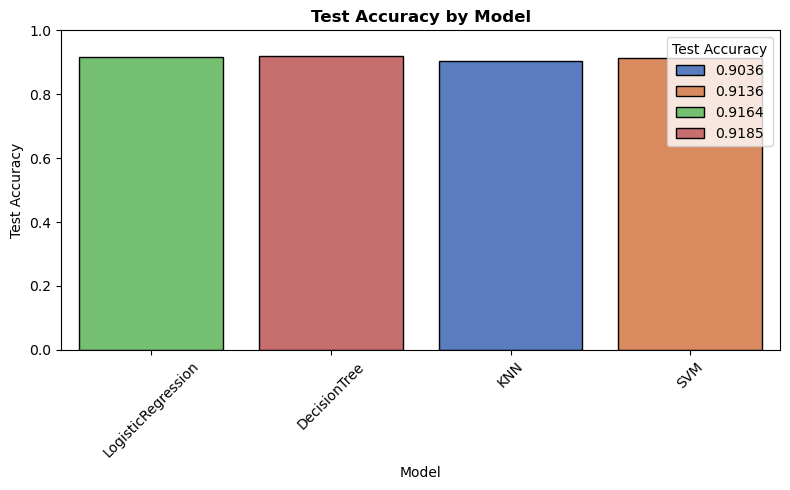

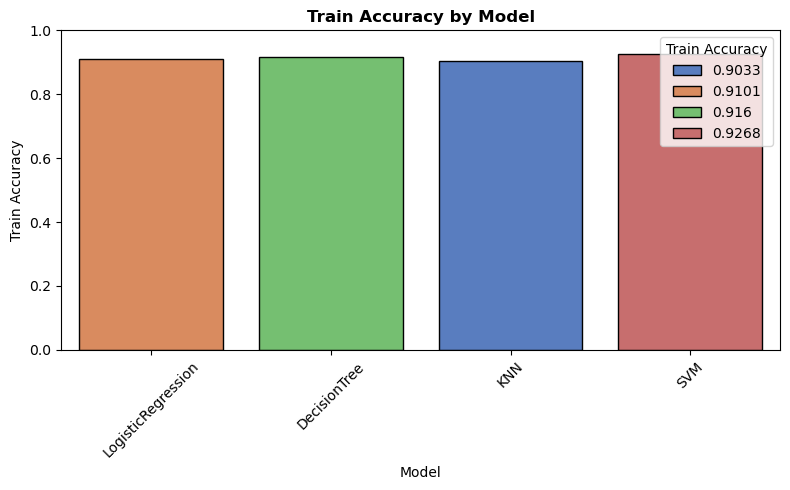

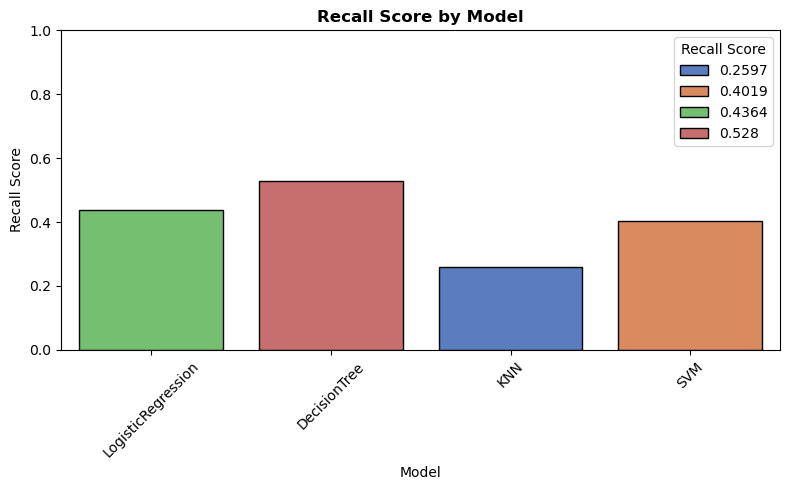

In [1080]:
# Comparing the results

# Plot model-level comparison
plt.figure(figsize=(8, 5))
sns.barplot(data=perf_metrics_df, x='Model', y='Train Time', edgecolor='black', palette='muted', hue="Train Time")
plt.title('Model training and prediction time', fontweight='bold')
plt.ylabel('Train and prediction time (log)')
plt.yscale('log')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(data=perf_metrics_df, x='Model', y='Test Accuracy', edgecolor='black', palette='muted', hue="Test Accuracy")
plt.title('Test Accuracy by Model', fontweight='bold')
plt.ylim(0, 1)
plt.ylabel('Test Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(data=perf_metrics_df, x='Model', y='Train Accuracy', edgecolor='black', palette='muted', hue="Train Accuracy")
plt.title('Train Accuracy by Model', fontweight='bold')
plt.ylim(0, 1)
plt.ylabel('Train Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 5))
sns.barplot(data=perf_metrics_df, x='Model', y='Recall Score', edgecolor='black', palette='muted', hue="Recall Score")
plt.title('Recall Score by Model', fontweight='bold')
plt.ylim(0, 1)
plt.ylabel('Recall Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Getting the Most important / influential features from the best models
Based on the performance metrics of each tuned model, we observe that best accuracy and least recall is for Logistic Regression Classifier and Support Vector Machine Classifier models. Let us get the most important features based on these tuned models and we recommend the action plan to improve the accptance rate. 

In [1084]:
# Extract top 5 most important features for Linear Regression Model

# Get model coefficients
lr_coefs = lr_grid.best_estimator_.named_steps['logisticRegression'].coef_[0]
feature_names = X_train.columns

# Create DataFrame of features and coefficients
lr_coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_coefs,
    'Abs_Coefficient': np.abs(lr_coefs)
})

# Sort by absolute influence and show top 5
lr_top_features = lr_coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(5)
lr_top_features

,Feature,Coefficient,Abs_Coefficient
5,emp.var.rate,-2.616459,2.616459
6,cons.price.idx,1.217072,1.217072
1,duration,1.199831,1.199831
8,euribor3m,0.520200,0.520200
9,nr.employed,0.369816,0.369816


In [1088]:
# Extract top 5 most important features for Support Vector Machine model
feature_names = X_train.columns
svm_result = permutation_importance(
    svm_grid.best_estimator_, X_test, y_test,
    n_repeats=3, random_state=42, n_jobs=1, scoring='accuracy'
)

# Create DataFrame for importance
svm_perm_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance_Mean': svm_result.importances_mean,
    'Importance_Std': svm_result.importances_std
})

# Sort and get top 5
svm_top_features = svm_perm_df.sort_values(by='Importance_Mean', ascending=False).head(5)
svm_top_features

,Feature,Importance_Mean,Importance_Std
1,duration,0.030590,0.001035
53,month_oct,0.005260,0.000921
9,nr.employed,0.004410,0.000468
62,poutcome_success,0.003763,0.000297
3,pdays,0.002792,0.000262


##### Questions